## 01_IMPORTS

In [1]:
#General

import pandas as pd
import matplotlib.pyplot as plt


#Embeddings
import re
from nltk.corpus import stopwords
import keras
from keras.layers import Dense, Activation, Input, Dropout
from keras.models import Model
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import gensim
from gensim.models import Word2Vec

#Recommender System mit SVD
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Bilder
from IPython.display import Image, display, HTML

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/flaviopfister/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 02 LOAD DATA

In [2]:
rating_df = pd.read_csv('01_Data/books_rating.csv')
books_df = pd.read_csv('01_Data/books_data.csv')

In [3]:
rating_df.shape

(3000000, 10)

In [4]:
rating_df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [5]:
#calculate how many users just gave one bad rating with 1 star
oneStar = rating_df[rating_df['review/score'] == 1].groupby('User_id').head(10)
print("Number of one star ratings: ", oneStar.shape[0])
print("Number of users with just one star rating: ", oneStar['User_id'].nunique())


Number of one star ratings:  146298
Number of users with just one star rating:  97503


In [6]:
# Fraction of NaN in Price
rating_df['Price'].isnull().sum()*100/len(rating_df)

83.96096666666666

In [7]:
# Drop Price Column
rating_df.drop('Price', axis=1, inplace=True)

In [8]:
# Drop review/helpfullnes column
rating_df.drop('review/helpfulness', axis=1, inplace=True)

In [9]:
# Drop review/summary column
rating_df.drop('review/summary', axis=1, inplace=True)

In [10]:
# Drop review/text column
rating_df.drop('review/text', axis=1, inplace=True)

In [11]:
# how many different Values are in the Id Column
print("Number of unique Id: ", rating_df['Id'].nunique())
print("Number of unique Users: ", rating_df['User_id'].nunique())



Number of unique Id:  221998
Number of unique Users:  1008972


In [12]:
#Number of reviews per User
rating_df.groupby('profileName')['Id'].agg('count').sort_values(ascending=False).head(20)

profileName
Midwest Book Review                   5817
A Customer                            5016
Harriet Klausner                      3606
E. A Solinas "ea_solinas"             3146
Shalom Freedman "Shalom Freedman"     1995
Blue Tyson "- Research Finished"      1804
John                                  1699
Donald Mitchell "Jesus Loves You!"    1457
bernie "xyzzy"                        1387
Avid Reader                           1383
Charles Ashbacher                     1312
Chris                                 1129
Sarah                                 1044
Mike                                  1038
S. Schwartz "romonko"                 1031
Steven H. Propp                       1001
David                                  975
Lawyeraau                              961
Reader                                 959
Anonymous                              951
Name: Id, dtype: int64

In [13]:
#average number of reviews per user
rating_df.groupby('profileName')['Id'].agg('count').sort_values(ascending=False).mean()

2.8544275269421466

In [14]:
#reformat the review/time column to actual date
rating_df['review/time'] = pd.to_datetime(rating_df['review/time'], unit='s')

In [15]:
rating_df

,Id,Title,User_id,profileName,review/score,review/time
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4.0,1999-10-23
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,5.0,2004-09-21
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,5.0,2004-03-09
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4.0,2004-07-25
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4.0,2005-02-10
...,...,...,...,...,...,...
2999995,B000NSLVCU,The Idea of History,NaN,NaN,4.0,1999-09-18
2999996,B000NSLVCU,The Idea of History,A1SMUB9ASL5L9Y,jafrank,4.0,2012-03-14
2999997,B000NSLVCU,The Idea of History,A2AQMEKZKK5EE4,"L. L. Poulos ""Muslim Mom""",4.0,2007-05-27
2999998,B000NSLVCU,The Idea of History,A18SQGYBKS852K,"Julia A. Klein ""knitting rat""",5.0,2006-11-09


array([[<Axes: title={'center': 'review/score'}>]], dtype=object)

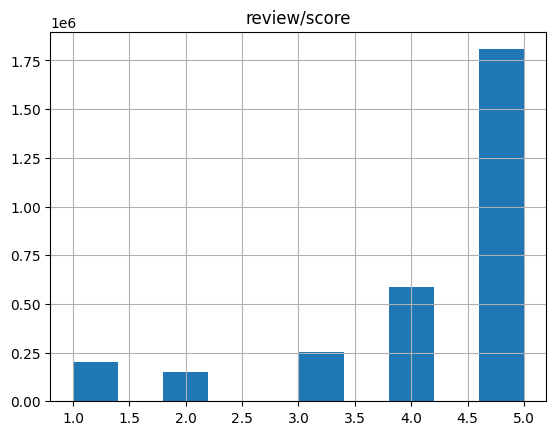

In [16]:
rating_df.hist('review/score')

## Books Dataset

In [131]:
books_df = pd.read_csv('01_Data/books_data.csv')
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    143962 non-null  object 
 2   authors        180991 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    188568 non-null  object 
 5   publisher      136518 non-null  object 
 6   publishedDate  187099 non-null  object 
 7   infoLink       188568 non-null  object 
 8   categories     171205 non-null  object 
 9   ratingsCount   49752 non-null   float64
dtypes: float64(1), object(9)
memory usage: 16.2+ MB


In [133]:
books_df.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [135]:
# Drop books with nan in image
books_df.dropna(subset=['image'], inplace=True)

books_df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 160329 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          160328 non-null  object 
 1   description    136957 non-null  object 
 2   authors        155027 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    160329 non-null  object 
 5   publisher      130183 non-null  object 
 6   publishedDate  159405 non-null  object 
 7   infoLink       160329 non-null  object 
 8   categories     151884 non-null  object 
 9   ratingsCount   47127 non-null   float64
dtypes: float64(1), object(9)
memory usage: 13.5+ MB


# Collabroative Filtering mit SVD

In [136]:
# get Image Link fro Book in row 0 and 1 and make a list
url = []
url.append(books_df['image'][0])
url.append(books_df['image'][1])


In [137]:
from IPython.display import Image, display, HTML

def display_books_in_row(urls, titles):
    images = [Image(url=url, width=150, height=190) for url in urls]
    display(HTML("<div>" + "".join([f"<div style='display:inline-block; padding:10px; text-align:center;'>{image._repr_html_()}<br>{title}</div>" for image, title in zip(images, titles)]) + "</div>"))

# Beispiel-Liste von Bild-URLs und Titeln
#url_list = ["url1.jpg", "url2.jpg", "url3.jpg"]
title_list = ["Buch 1", "Buch 2", "Buch 3"]

# Die Funktion aufrufen, um die Bilder und Titel nebeneinander anzuzeigen
display_books_in_row(url, title_list)


In [138]:
# Merge the two dataframes by Title
df = pd.merge(rating_df, books_df, on='Title')

# Drop the Id column
df.drop('ratingsCount', axis=1, inplace=True) # seems to be wrong data

# Count numbers of reviews per book and add it to the dataframe
df['number_of_reviews'] = df.groupby('Title')['Title'].transform('count')

len(df)

2459694

In [139]:
# drop all books with less than 20 reviews

df = df[df['number_of_reviews'] >= 50]
len(df)

1509689

In [140]:
# drop unnecessary columns
df.drop('profileName', axis=1, inplace=True)
df.drop('review/time', axis=1, inplace=True)
df.drop('description', axis=1, inplace=True)
df.drop('authors', axis=1, inplace=True)
df.drop('previewLink', axis=1, inplace=True)
df.drop('publisher', axis=1, inplace=True)
df.drop('image', axis=1, inplace=True)
df.drop('publishedDate', axis=1, inplace=True)
df.drop('infoLink', axis=1, inplace=True)
df.drop('categories', axis=1, inplace=True)
#df.drop('ratingsCount', axis=1, inplace=True)

# rename the column
df.rename(columns={'review/score': 'rating'}, inplace=True)
df.rename(columns={'Id': 'book_id'}, inplace=True)
df.rename(columns={'Title': 'title'}, inplace=True)
df.rename(columns={'User_id': 'user_id'}, inplace=True)

df

,book_id,title,user_id,rating,number_of_reviews
360,0671551345,Night World: Daughters Of Darkness,ADB0JID2XRFYR,5.0,134.0
361,0671551345,Night World: Daughters Of Darkness,NaN,5.0,134.0
362,0671551345,Night World: Daughters Of Darkness,NaN,3.0,134.0
363,0671551345,Night World: Daughters Of Darkness,A1V0SFB3AXM8JK,1.0,134.0
364,0671551345,Night World: Daughters Of Darkness,NaN,5.0,134.0
...,...,...,...,...,...
2459395,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,A2E55F0514C3UG,1.0,96.0
2459396,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AUEN15WF0UAMJ,1.0,96.0
2459397,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,NaN,1.0,96.0
2459398,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AWF6YB8EKN2C6,2.0,96.0


In [141]:
# show all ratings from User AZZQLMNX239VT
df[df['user_id'] == 'AZZQLMNX239VT']

,book_id,title,user_id,rating,number_of_reviews
913204,B000P5ISWW,The Brothers Karamazov: A Modern Library Book ...,AZZQLMNX239VT,4.0,119.0
1103862,B000I364KE,Anna Karenina - translated from the Russian by...,AZZQLMNX239VT,5.0,505.0
1222166,B000MCJWZ0,Anna Karenina,AZZQLMNX239VT,5.0,850.0
2317819,B000GR6DWQ,The Brothers Karamazov (A Signet Classic CT33),AZZQLMNX239VT,4.0,120.0


In [142]:
# drop all reviews with NaN user_id
df = df.dropna(subset=['user_id'])
df

,book_id,title,user_id,rating,number_of_reviews
360,0671551345,Night World: Daughters Of Darkness,ADB0JID2XRFYR,5.0,134.0
363,0671551345,Night World: Daughters Of Darkness,A1V0SFB3AXM8JK,1.0,134.0
366,0671551345,Night World: Daughters Of Darkness,AODBNCTX9L1L5,5.0,134.0
378,0671551345,Night World: Daughters Of Darkness,A107F528SN3XJU,5.0,134.0
380,0671551345,Night World: Daughters Of Darkness,AXYESYR1GNGM0,5.0,134.0
...,...,...,...,...,...
2459394,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,A2NNMPFZWPMT1L,5.0,96.0
2459395,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,A2E55F0514C3UG,1.0,96.0
2459396,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AUEN15WF0UAMJ,1.0,96.0
2459398,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AWF6YB8EKN2C6,2.0,96.0


In [143]:
# Count numbers of reviews per user and add it to the dataframe
df['number_of_reviews_user'] = df.groupby('user_id')['user_id'].transform('count')

/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_24478/1570438464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['number_of_reviews_user'] = df.groupby('user_id')['user_id'].transform('count')


In [144]:
df = df[df['number_of_reviews_user'] >= 5]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 599131 entries, 382 to 2459399
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   book_id                 599131 non-null  object 
 1   title                   599131 non-null  object 
 2   user_id                 599131 non-null  object 
 3   rating                  599131 non-null  float64
 4   number_of_reviews       599131 non-null  float64
 5   number_of_reviews_user  599131 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 32.0+ MB


In [145]:
df.drop_duplicates(['user_id','title'], inplace=True)

/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_24478/4139203282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['user_id','title'], inplace=True)


In [146]:
# Create Pivot Table

ratings = df.pivot(columns='title', index='user_id', values="rating")
# replace NaN with 0
ratings.fillna(0, inplace=True)
ratings


title,"""A"" IS FOR ALIBI","""C"" is for Corpse (A Kinsey Millhone mystery, Book 3)","""D"" is for Deadbeat","""Hey, Whipple, Squeeze This"": A Guide to Creating Great Ads (Adweek Magazine Series)","""Stand back,"" said the elephant, ""I'm going to sneeze!""","""Why Should White Guys Have All the Fun"": How Reginald Lewis Created a Billion-Dollar Business Empire","(ESV) English Standard Version Large Print Bible. Premium Bonded Leather, Black, Red Letter Text (English Language)","1,000 Places to See Before You Die: A Traveler's Life List","1,000 Vegetarian Recipes","1,000 Years, 1,000 People: Ranking the Men and Women Who Shaped the Millennium",...,"that quail, robert",the Enemy Within,the Picture of Dorian Gray,the Sword and the Stone,the art Spirit,the great brain,the heart of a dog,the lion's paw,the story of ferdinand,ttyl
user_id,,,,,,,,,,,,,,,,,,,,,
A00540411RKGTDNU543WS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00878773S2MNB00COHKV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00891092QIVH4W1YP46A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01038432MVI9JXYTTK5T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01254073JW8SSTKH6AIB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZEEEPUSM034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZHSA4KMGXG7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZK8T7V8NQ9N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
# Erstellen Sie eine Kopie Ihrer Tabelle, um die Vorhersagen darauf anzuwenden.
predicted_ratings = ratings.copy()

In [148]:
from scipy.sparse import csr_matrix

sparse_ratings = csr_matrix(ratings.values)

In [149]:
import implicit
als_model = implicit.als.AlternatingLeastSquares(factors=10)
als_model.fit(sparse_ratings.T)  # Transponieren Sie die Sparse-Matrix


# Verwenden Sie die gelernten Faktoren, um Vorhersagen zu generieren
predicted_ratings = np.dot(als_model.user_factors, als_model.item_factors.T)


/Users/flaviopfister/anaconda3/envs/rs/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0022230148315429688 seconds
  warnings.warn(
100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


In [150]:
predicted_ratings.shape 
predicted_ratings = predicted_ratings.T
predicted_ratings.shape

(50375, 7071)

In [151]:
predicted_ratings

array([[-2.0559346e-03, -2.9964084e-03, -4.2445967e-03, ...,
        -3.9367209e-04,  3.2737579e-03,  6.3311163e-04],
       [-2.0559323e-03, -2.9964077e-03, -4.2445986e-03, ...,
        -3.9367203e-04,  3.2737597e-03,  6.3311186e-04],
       [-1.7276095e-03, -3.0352946e-04,  9.5983909e-04, ...,
        -1.9702125e-04, -1.1059589e-03,  1.4840878e-03],
       ...,
       [-2.0559332e-03, -2.9964077e-03, -4.2445981e-03, ...,
        -3.9367212e-04,  3.2737576e-03,  6.3311151e-04],
       [ 4.1492577e-03,  4.4037341e-03,  4.3212017e-03, ...,
         7.4965319e-05,  2.2013474e-03,  2.4817782e-04],
       [ 1.0996462e-02,  7.6020714e-03,  6.3482285e-03, ...,
         3.4712857e-04,  3.6420573e-03,  1.4324983e-03]], dtype=float32)

In [152]:
# create a pivot dataframe from the predicted ratings with the same columns and index as the original ratings dataframe
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=ratings.columns, index=ratings.index)

predicted_ratings_df

title,"""A"" IS FOR ALIBI","""C"" is for Corpse (A Kinsey Millhone mystery, Book 3)","""D"" is for Deadbeat","""Hey, Whipple, Squeeze This"": A Guide to Creating Great Ads (Adweek Magazine Series)","""Stand back,"" said the elephant, ""I'm going to sneeze!""","""Why Should White Guys Have All the Fun"": How Reginald Lewis Created a Billion-Dollar Business Empire","(ESV) English Standard Version Large Print Bible. Premium Bonded Leather, Black, Red Letter Text (English Language)","1,000 Places to See Before You Die: A Traveler's Life List","1,000 Vegetarian Recipes","1,000 Years, 1,000 People: Ranking the Men and Women Who Shaped the Millennium",...,"that quail, robert",the Enemy Within,the Picture of Dorian Gray,the Sword and the Stone,the art Spirit,the great brain,the heart of a dog,the lion's paw,the story of ferdinand,ttyl
user_id,,,,,,,,,,,,,,,,,,,,,
A00540411RKGTDNU543WS,-0.002056,-0.002996,-0.004245,-0.001410,0.000730,-0.000210,-0.000152,-0.003725,-2.512296e-05,-0.000020,...,-0.000234,0.000300,-0.019503,0.002855,0.001126,0.004123,-0.001608,-0.000394,0.003274,0.000633
A00878773S2MNB00COHKV,-0.002056,-0.002996,-0.004245,-0.001410,0.000730,-0.000210,-0.000152,-0.003725,-2.512296e-05,-0.000020,...,-0.000234,0.000300,-0.019503,0.002855,0.001126,0.004123,-0.001608,-0.000394,0.003274,0.000633
A00891092QIVH4W1YP46A,-0.001728,-0.000304,0.000960,0.000092,0.000233,-0.000433,0.000689,-0.001114,-3.940817e-08,-0.000034,...,0.000980,-0.001397,0.082828,-0.001156,0.001573,-0.002077,0.001453,-0.000197,-0.001106,0.001484
A01038432MVI9JXYTTK5T,-0.005754,-0.002441,-0.001762,-0.001971,0.001128,-0.000762,-0.001381,-0.007712,-5.478368e-05,0.000035,...,0.000668,0.000446,0.517600,0.014093,0.002245,0.011888,0.004608,-0.000413,0.006717,0.002664
A01254073JW8SSTKH6AIB,-0.002718,-0.000479,0.001508,0.000144,0.000367,-0.000682,0.001084,-0.001756,-7.598851e-08,-0.000053,...,0.001541,-0.002197,0.130232,-0.001817,0.002474,-0.003265,0.002286,-0.000310,-0.001737,0.002334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZEEEPUSM034,-0.004773,-0.005565,-0.006735,0.000696,-0.000597,-0.000422,0.000420,-0.001916,-2.523168e-05,-0.000021,...,0.002209,-0.001994,-0.094037,-0.003609,0.003422,0.000736,0.005149,-0.000091,0.001581,-0.001157
AZZHSA4KMGXG7,0.005514,0.003680,0.002974,0.000653,0.000660,0.000268,0.000275,0.005959,1.256219e-05,0.000008,...,0.000687,0.000288,-0.007676,0.001219,0.000998,0.000346,0.002658,0.000203,0.002198,0.000558
AZZK8T7V8NQ9N,-0.002056,-0.002996,-0.004245,-0.001410,0.000730,-0.000210,-0.000152,-0.003725,-2.512296e-05,-0.000020,...,-0.000234,0.000300,-0.019503,0.002855,0.001126,0.004123,-0.001608,-0.000394,0.003274,0.000633


In [243]:
# Funktion zum Abrufen der Top-Bücher für einen bestimmten Benutzer

def get_top_books_for_user(user_id, predicted_ratings_df, num_books=5):
    """
    Diese Funktion gibt die Top-Bücher für einen bestimmten Benutzer basierend auf den Vorhersagen zurück.
    
    :param user_id: Die Benutzer-ID für den Benutzer, für den Empfehlungen erstellt werden sollen.
    :param predicted_ratings_df: Der DataFrame mit den Vorhersagen (Benutzer x Bücher).
    :param num_books: Die Anzahl der Empfehlungen, die zurückgegeben werden sollen (Standardmäßig 5).
    :return: Eine Liste der Top-Bücher für den Benutzer.
    """
    user_ratings = predicted_ratings_df.loc[user_id]
    
    # Sortieren Sie die Bücher nach ihren Vorhersagen für den spezifischen Benutzer in absteigender Reihenfolge
    sorted_books = user_ratings.sort_values(ascending=False)
    
    # Wählen Sie die Top-Bücher aus
    top_books = sorted_books.head(num_books).index.tolist()
    return top_books


#print(f"Empfehlungen für Benutzer {user_id}: {recommendations}")

In [244]:
# Funktion die die Links zu den Büchern zurückgibt

def get_book_links(book_ids):
    """
    Diese Funktion gibt die Links zu den Büchern zurück.
    
    :param book_ids: Die Buch-IDs für die Links zurückgegeben werden sollen.
    :return: Eine Liste der Links zu den Büchern.
    """
    links = []
    for book_id in book_ids:
        links.append(books_df[books_df['Title'] == book_id]['image'].values[0])
    return links

In [246]:
# Funktion für die Anzeige der Bilder

def display_books_in_row(titles, urls):
    #urls = books_df[books_df['Title'].isin(titles)]['image'].tolist()
    images = [Image(url=url, width=150, height=190) for url in urls]
    display(HTML("<div>" + "".join([f"<div style='display:inline-block; padding:10px; text-align:center;'>{image._repr_html_()}<br>{title}</div>" for image, title in zip(images, titles)]) + "</div>"))    


In [247]:
# Funktion die eine zufällige user_id zurückgibt

def get_random_user_id():
    """
    Diese Funktion gibt eine zufällige Benutzer-ID zurück.
    
    :return: Eine zufällige Benutzer-ID.
    """
    return ratings.sample().index[0]


In [272]:
user = get_random_user_id()
books = get_top_books_for_user(user, predicted_ratings_df, num_books=5)
urls = get_book_links(books)
display_books_in_row(books, urls)

In [274]:
user_ratings = predicted_ratings_df.loc[user] 
sorted_books = user_ratings.sort_values(ascending=False)

sorted_books

title
A Tree Grows in Brooklyn                                      0.629815
A Tree Grows in Brooklyn by Smith, Betty                      0.629815
A tree grows in Brooklyn: A novel (Armed Services edition)    0.629815
Great Expectations                                            0.563147
Great Expectations (Enriched Classics)                        0.563147
                                                                ...   
Nineteen Eighty-four                                         -0.424591
The Count of Monte Cristo                                    -0.602823
The count of Monte Cristo (The novels of Alexandre Dumas)    -0.602823
Count of Monte Cristo                                        -0.602965
Monte Cristo,                                                -0.602973
Name: A18KAC7DFVE3E3, Length: 7071, dtype: float32

In [219]:
# get Link to the book Harry Potter and The Sorcerer's Stone
books_df[books_df['Title'] == "1984"]['infoLink'].tolist()[0]


'https://play.google.com/store/books/details?id=gTx1AAAAQBAJ&source=gbs_api'

In [29]:
#get all unique categories
categories = df['categories'].unique()
categories

array(["['Comics & Graphic Novels']", "['Biography & Autobiography']",
       "['Religion']", ..., "['Basilicas']", "['Beguines']",
       "['Occult sciences']"], dtype=object)

In [30]:
# get description of the book with index 1
books_df.loc[3, 'description']

'Julia Thomas finds her life spinning out of control after the death of her husband, Richard. Julia turns to her minister for comfort when she finds herself falling for him with a passion that is forbidden by the church. Heath Sparks is a man of God who is busy taking care of his quadriplegic wife who was seriously injured in a sever car accident. In an innocent effort to reach out to a lonely member of his church, Heath finds himself as the man and not the minister as Heath and Julia surrender their bodies to each other and face the wrath of God. Julia finds herself in over her head as she faces a deadly disease, the loss of her home and whispers about her wicked affair. Julia leaves the states offering her body as a living sacrifice in hopes of finding a cure while her heart remains thousands of miles away hoping to one day reunite with the man who holds it hostage.Whispers of the Wicked Saints is a once in a lifetime romance that is breath taking, defying all the rules of romance an

In [31]:
# Drop all rows with NaN values in the description column
# Word2Vec Tokenizer hat Probleme mit NaN Values

books_df = books_df.dropna(subset=['description'])
books_df

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,['Mary Fabyan Windeatt'],http://books.google.com/books/content?id=lmLqA...,http://books.google.nl/books?id=lmLqAAAACAAJ&d...,Tan Books & Pub,2009-01-01,http://books.google.nl/books?id=lmLqAAAACAAJ&d...,['Biography & Autobiography'],NaN
...,...,...,...,...,...,...,...,...,...,...
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],http://books.google.com/books/content?id=J7M-N...,http://books.google.com/books?id=J7M-NwAACAAJ&...,Scholastic Paperbacks,2000-06-01,http://books.google.com/books?id=J7M-NwAACAAJ&...,['Juvenile Fiction'],2.0
212400,Red Boots for Christmas,Everyone in the village of Friedensdorf is hap...,NaN,http://books.google.com/books/content?id=3n8k6...,http://books.google.com/books?id=3n8k6wl4BbYC&...,NaN,1995,http://books.google.com/books?id=3n8k6wl4BbYC&...,['Juvenile Fiction'],NaN
212401,Mamaw,"Give your Mamaw a useful, beautiful and though...",['Wild Wild Cabbage'],NaN,http://books.google.com/books?id=zytVswEACAAJ&...,NaN,2018-01-17,http://books.google.com/books?id=zytVswEACAAJ&...,NaN,NaN
212402,The Autograph Man,Alex-Li Tandem sells autographs. His business ...,['Zadie Smith'],http://books.google.com/books/content?id=JM6YV...,http://books.google.com/books?id=JM6YVPx_clMC&...,Vintage,2003-08-12,https://play.google.com/store/books/details?id...,['Fiction'],19.0


In [32]:
# how many Nan values in the description column
books_df.description.isna().sum()

0

In [33]:
# fraction of Nan values in the description column
books_df.description.isna().sum() / len(books_df)


0.0

# Embedding mit Roberta

In [19]:
from transformers import AutoTokenizer, TFRobertaModel
import tensorflow as tf

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = TFRobertaModel.from_pretrained("roberta-base")

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
outputs = model(inputs)

last_hidden_states = outputs.last_hidden_state

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [20]:
last_hidden_states.shape

TensorShape([1, 8, 768])

# Embedding mit Doc2Vec

In [34]:
books_df.head(4)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0


In [5]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [6]:
tagged_data = [TaggedDocument(words=word_tokenize(text.lower()), tags=[str(i)]) for i, text in enumerate(books_df['description'])]

In [12]:
model = Doc2Vec(vector_size=250, window=5, min_count=1, epochs=10)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [13]:
# nur zum Testen

text_to_embed = 'Julia Thomas finds her life spinning out of control after the death of her husband, Richard. Julia turns to her minister for comfort when she finds herself falling for him with a passion that is forbidden by the church. Heath Sparks is a man of God who is busy taking care of his quadriplegic wife who was seriously injured in a sever car accident. In an innocent effort to reach out to a lonely member of his church, Heath finds himself as the man and not the minister as Heath and Julia surrender their bodies to each other and face the wrath of God. Julia finds herself in over her head as she faces a deadly disease, the loss of her home and whispers about her wicked affair. Julia leaves the states offering her body as a living sacrifice in hopes of finding a cure while her heart remains thousands of miles away hoping to one day reunite with the man who holds it hostage.Whispers of the Wicked Saints is a once in a lifetime romance that is breath taking, defying all the rules of romance and bending the laws of love.'
embeddings = model.infer_vector(word_tokenize(text_to_embed.lower()))

In [14]:
embeddings.shape

(250,)

In [15]:
similar_documents = model.docvecs.most_similar(positive=[embeddings])

/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_29563/2076206324.py:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_documents = model.docvecs.most_similar(positive=[embeddings])


In [16]:
similar_documents

[('2', 0.8409636616706848),
 ('51500', 0.5312236547470093),
 ('35536', 0.5245327353477478),
 ('85602', 0.5213347673416138),
 ('72950', 0.5208823680877686),
 ('10754', 0.5130080580711365),
 ('11513', 0.5114008188247681),
 ('2956', 0.510870099067688),
 ('39049', 0.5044835209846497),
 ('16335', 0.504027783870697)]

In [17]:
# berechne EMbeddings für alle Bücher und speichere sie als Liste in der Spalte 'embeddings'
books_df['embeddings'] = books_df['description'].apply(lambda x: model.infer_vector(word_tokenize(x.lower())))
books_df.head(4)


,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,embeddings
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,"[-0.079611614, 0.035406318, 0.02624479, -0.144..."
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN,"[-0.026491754, -0.09063662, 0.070626244, 0.024..."
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN,"[0.1185066, 0.32673895, 0.31888542, 0.4379063,..."
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0,"[0.05028091, 0.2058532, 0.048282508, 0.1160490..."


In [21]:
# save the dataframe as csv
books_df.to_csv('01_Data/books_data_embeddings.csv', index=False)


In [22]:
# load the dataframe
new_df = pd.read_csv('01_Data/books_data_embeddings.csv')
new_df.head(4)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,embeddings
0,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,[-0.07961161 0.03540632 0.02624479 -0.144790...
1,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN,[-0.02649175 -0.09063662 0.07062624 0.024100...
2,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN,[ 0.1185066 0.32673895 0.31888542 0.437906...
3,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0,[ 0.05028091 0.2058532 0.04828251 0.116049...


'[-0.02649175 -0.09063662  0.07062624  0.02410002 -0.14816006  0.06495572\n -0.01645727 -0.02856826 -0.1919003  -0.06293503 -0.0454542   0.12363559\n -0.06591933 -0.0637741   0.21488747 -0.06329649 -0.11098704 -0.10047992\n  0.08763832  0.00871943 -0.14898314 -0.04981707  0.14519759  0.07434004\n -0.07262353  0.03468617 -0.1569493   0.00546149 -0.01595293  0.06952457\n -0.16100043  0.03288672  0.00200741  0.08242749 -0.01631511  0.04057562\n  0.05518447 -0.08722182  0.04510799 -0.10538185 -0.07414316  0.16290404\n  0.05375646  0.03662929  0.12917553  0.15212566  0.00167859  0.00794531\n -0.1003027   0.0244045  -0.09077305 -0.12022645  0.00031969  0.01587192\n -0.10963157  0.03779404 -0.05209028 -0.2137903  -0.09584818 -0.07023893\n  0.03006833  0.04817367 -0.05350181 -0.08870592 -0.04351221  0.07684905\n  0.03598317 -0.05122747  0.13037527  0.06486007  0.05384667 -0.06867152\n  0.08374285 -0.15468821 -0.02450805  0.08247822  0.10089578 -0.01047227\n  0.05317754 -0.05627755 -0.01695672 